# HSQL sums and spider plots

First part creates HQSL.

By changing parameters_dict:
* __'santiago_hexproximity_hqsl_4_5_kmh'__ includes _priv source names from educational categories.
* __'santiago_hexproximity_hqsl_4_5_kmh_pub'__ does __NOT__ include _priv source names from educational categories.

_priv source names from educational categories: 'jardin_inf_priv','edu_especial_priv','edu_basica_priv','edu_media_priv','edu_adultos_priv'

Second part uses created HQSL to analyse statistical data and create plots

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Notebook config

In [21]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = True

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'alex'

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [12]:
# --- REQUIRED DATA: parameters dictionary
# Structure: {social_functions:{themes:[source_names]}}

parameters_dict = {'supplying':{'groceries':['carniceria','hogar','local_mini_market',
                                             'bakeries','ferias','supermercado'],
                                'services':['centro_recyc'],
                               },
                   'caring':{'health':['clinica_priv','clinica_pub',
                                       'hospital_priv','hospital_pub',
                                       'vacunatorio_priv','vacunatorio_pub',
                                       'consult_ado_priv','consult_ado_pub',
                                       'salud_mental','labs_priv','residencia_adumayor','farmacia'],
                             'public_wellbeing':['bomberos'],
                             'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']
                            },
                   'living':{'errands_paperwork':['civic_office','tax_collection',
                                                  'social_security','correos','banco'],
                             'housing':['viv_count','viv_social_count'],
                             'public_services':['police'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big'],
                             'temporary_residence':['hotel_count']
                            },
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'greenspace':['ndvi_count'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']
                              },
                   'learning':{'education':['jardin_inf_pub','jardin_inf_priv',
                                            'edu_especial_pub','edu_especial_priv',
                                            'edu_basica_pub','edu_basica_priv',
                                            'edu_media_pub','edu_media_priv',
                                            'edu_tecnica','universidad',
                                            'edu_adultos_pub','edu_adultos_priv',
                                            'centro_edu_amb']
                              },
                   'working':{'workplaces':['oficinas_count'],
                              'sustainable_mobility':['ciclovias','paradas_tp',
                                                      'paradas_tp_tren','paradas_tp_metro']}
                  }

## Load data

### Load data - Load hexagons with proximity data

__Low resolution data__ -- used to extract max proximity opportunities

In [5]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = 8'
hex_low_res = aup.gdf_from_query(query)

# Show
print(hex_low_res.shape)
hex_low_res.head(1)

(4291, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,88b2c0b5d9fffff,"POLYGON ((-70.86282 -33.80799, -70.86725 -33.8...",190.999017,0.0,224.67341,0.0,4.5806,1.0,636.436136,0.0,...,4.592671,1.888889,182.048447,0.0,102.399114,0.0,185.239877,0.0,8,Santiago


In [6]:
if all_local_dirs == 'alex':
    hex_dir = "../../../data/processed/santiago/aereal_data/hex_aereal_res8.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = '../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res8.gpkg'

hex_aereal_res8 = gpd.read_file(hex_dir)

# Show
print(hex_aereal_res8.shape)
hex_aereal_res8.head(1)

(1310, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,88b2c550cbfffff,0.201249,3.010988,0.0,0.0,0.130288,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3..."


In [7]:
hex_low_res = hex_low_res.merge(hex_aereal_res8.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
# Show
print(hex_low_res.shape)
hex_low_res.head(2)

(1310, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,88b2c550cbfffff,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3...",23.226005,0.0,30.952702,0.0,42.249569,0.0,161.848656,0.0,...,0.0,77.053437,0.0,8.0,Santiago,0.201249,3.010988,0.0,0.0,0.130288
1,88b2c51859fffff,"POLYGON ((-70.49165 -33.33520, -70.49606 -33.3...",41.387994,0.0,51.758445,0.0,39.769928,0.0,129.364726,0.0,...,0.0,53.782026,0.0,8.0,Santiago,1.144057,0.000119,0.0,0.0,0.312631


__High resolution data__ -- used for HQSL urban analysis

In [8]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = 10'
hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(210519, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,8ab2c0b00007fff,"POLYGON ((-71.00842 -33.71206, -71.00905 -33.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,Santiago


In [9]:
if all_local_dirs == 'alex':
    hex_dir = "../../../data/processed/santiago/aereal_data/hex_aereal_res10.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = '../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res10.gpkg'
    
hex_aereal = gpd.read_file(hex_dir)

# Show
print(hex_aereal.shape)
hex_aereal.head(1)

(64190, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,8ab2c5540647fff,51.747597,1.186889,7.023599,0.0,0.135445,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4..."


In [10]:
hex_gdf = hex_gdf.merge(hex_aereal.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
print(hex_gdf.shape)
hex_gdf.head(2)

(64190, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.0,6.049196,2.0,7.580963,2.0,50.542861,0.0,...,16.0,7.393075,4.0,10.0,Santiago,51.747597,1.186889,7.023599,0.0,0.135445
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,10.0,Santiago,0.000000,0.000000,0.000000,0.0,0.287743


<Axes: >

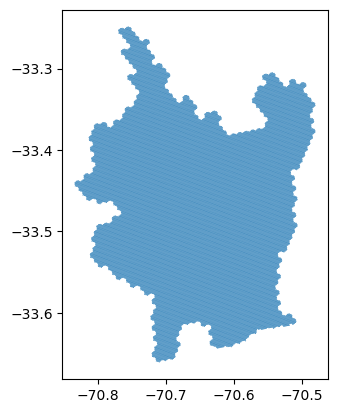

In [11]:
hex_gdf.plot()

## Pre-process data - Create HQSL

HQSL

In [13]:
def calculate_hqsl(hex_gdf, hex_low_res, scale_max_value, parameters_dict):

    # ------------------------------------------------------------
    # --- NORMALIZE SOURCES (_scaledcount columns)
    for social_function in parameters_dict.keys():
        aup.log(f"--- {social_function}")
        for theme in parameters_dict[social_function]:
            aup.log(f"------ {theme}")
            for source in parameters_dict[social_function][theme]:

                # Set col name of interest and find min and max values
                if 'count' in source:
                    count_colname = source
                else:
                    count_colname = f"{source}_count_15min"

                # Prepare for MinMax Scalar
                hex_gdf[count_colname] = hex_gdf[count_colname] + 0.001
                min_val = np.log(0.001)
                max_val = np.log(hex_low_res[count_colname]).max()
                print(f"for col {count_colname} original max_val: {hex_gdf[count_colname].max()} and min_val: {hex_gdf[count_colname].min()}")
                print(f"for col {count_colname} log max_val: {max_val} and min_val: {min_val}")

                # Calculate MinMax Scalar
                # scale_max_value = 10
                hex_gdf[f"{source}_scaledcount"] = hex_gdf[count_colname].apply(lambda x: scale_max_value * ((np.log(x) - min_val) /(max_val - min_val)))
                hex_gdf.loc[hex_gdf[f"{source}_scaledcount"]>scale_max_value, f"{source}_scaledcount"] = scale_max_value
                aup.log(f"------ Scaled {source} count.")
                ''' # Drop original count col
                hex_gdf.drop(columns=[count_colname],inplace=True)
                # Add
                scalar_count_column_list.append(f"{source}_scaledcount")'''

    aup.log(f"--- Scaled count columns added to hex_gdf.")
    
    # Keep columns of interest only
    # proxhexs_countprocess = proxhexs_countprocess[['hex_id','geometry']+scalar_count_column_list+['res','city']]

    # ------------------------------------------------------------
    # --- SUM NORMALIZED SOURCES BY THEME AND BY SOCIAL FUNCTION
    aup.log(f"--- Starting social function analysis.")
    sum_count_column_list = []

    for social_function in parameters_dict.keys():
        # Set social function sources list
        sf_sources_list = []
        
        for theme in parameters_dict[social_function]:
            # Set theme_sources_list and feed sf_sources_list
            theme_sources_list = []
            for source in parameters_dict[social_function][theme]:
                theme_sources_list.append(f"{source}_scaledcount")
                sf_sources_list.append(f"{source}_scaledcount")
                
            # Find sum of count anlysis for theme
            hex_gdf[f"{theme}_count"] = hex_gdf[theme_sources_list].sum(axis=1)
            aup.log(f"------ Summed {theme} count with a mean value of " + str(round(hex_gdf[f"{theme}_count"].mean(),4)))
            sum_count_column_list.append(f"{theme}_count")
            
        # Find sum of count anlysis for social function
        hex_gdf[f"{social_function}_count"] = hex_gdf[sf_sources_list].sum(axis=1)
        aup.log(f"--- Summed {social_function} count with a mean value of {round(hex_gdf[f'{social_function}_count'].mean(),4)}.")
        sum_count_column_list.append(f"{social_function}_count")

    # ------------------------------------------------------------
    # --- NORMALIZE SOCIAL FUNCTION COLUMNS AND CREATE HQLS
    # Get social function count columns
    social_fn_cols = []
    for k in parameters_dict.keys():
        social_fn_cols.append(k+'_count')

    # Normalize social function columns before creating HQSL
    for sc in social_fn_cols:
        aup.log(f"--- Normalized social function {sc} from 0 to 30.")
        hex_gdf[sc] = 30 * (hex_gdf[sc] - hex_gdf[sc].min()) / (hex_gdf[sc].max() - hex_gdf[sc].min())
        hex_gdf.loc[hex_gdf.supermercado_time==0, sc] = hex_gdf.loc[hex_gdf.supermercado_time==0].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_gdf,
                                                                            sc), axis=1)

    # Create HQSL
    hex_gdf['hqsl'] = hex_gdf[social_fn_cols[0]] + hex_gdf[social_fn_cols[1]] + hex_gdf[social_fn_cols[2]] + hex_gdf[social_fn_cols[3]] + hex_gdf[social_fn_cols[4]] + hex_gdf[social_fn_cols[5]]
    aup.log(f"--- Calculated HQSL with a mean value of {round(hex_gdf['hqsl'].mean(),4)}.")
    
    return hex_gdf

Filter hexs with no nodes before running HQSL

In [14]:
hex_diss = hex_low_res.loc[hex_low_res.supermercado_time>0].dissolve()
hex_clip = gpd.clip(hex_gdf, hex_diss)
hex_id_list = list(hex_clip.hex_id.unique())
hex_gdf = hex_gdf.loc[hex_gdf.hex_id.isin(hex_id_list)].copy()

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(63727, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.0,6.049196,2.0,7.580963,2.0,50.542861,0.0,...,16.0,7.393075,4.0,10.0,Santiago,51.747597,1.186889,7.023599,0.0,0.135445


<Axes: >

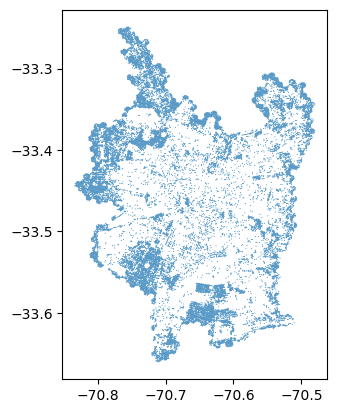

In [15]:
hex_gdf.loc[hex_gdf.supermercado_time==0].plot()

Create HQSL

In [16]:
hex_gdf = calculate_hqsl(hex_gdf, hex_low_res, 10, parameters_dict)

for col carniceria_count_15min original max_val: 11.001 and min_val: 0.001
for col carniceria_count_15min log max_val: 2.2079198664529676 and min_val: -6.907755278982137
for col hogar_count_15min original max_val: 28.001 and min_val: 0.001
for col hogar_count_15min log max_val: 3.0666840095262753 and min_val: -6.907755278982137
for col local_mini_market_count_15min original max_val: 100.001 and min_val: 0.001
for col local_mini_market_count_15min log max_val: 4.460121566456197 and min_val: -6.907755278982137
for col bakeries_count_15min original max_val: 52.001 and min_val: 0.001
for col bakeries_count_15min log max_val: 3.780748201004849 and min_val: -6.907755278982137
for col ferias_count_15min original max_val: 9.001 and min_val: 0.001
for col ferias_count_15min log max_val: 1.997425372002954 and min_val: -6.907755278982137
for col supermercado_count_15min original max_val: 15.917666666666666 and min_val: 0.001
for col supermercado_count_15min log max_val: 2.5641720546629747 and min

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col museos_pub_count_15min original max_val: 9.001 and min_val: 0.001
for col museos_pub_count_15min log max_val: 1.9818030721159199 and min_val: -6.907755278982137
for col bibliotecas_count_15min original max_val: 2.001 and min_val: 0.001
for col bibliotecas_count_15min log max_val: 0.6931471805599453 and min_val: -6.907755278982137
for col sitios_historicos_count_15min original max_val: 66.501 and min_val: 0.001
for col sitios_historicos_count_15min log max_val: 3.983847174624248 and min_val: -6.907755278982137
for col ndvi_count original max_val: 0.6981733927726745 and min_val: -0.31825637742135093
for col ndvi_count log max_val: -0.7539983600866187 and min_val: -6.907755278982137
for col cines_count_15min original max_val: 11.001 and min_val: 0.001
for col cines_count_15min log max_val: 2.193341077309822 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col librerias_count_15min original max_val: 24.001 and min_val: 0.001
for col librerias_count_15min log max_val: 3.0029734348105506 and min_val: -6.907755278982137
for col restaurantes_bar_cafe_count_15min original max_val: 189.201 and min_val: 0.001
for col restaurantes_bar_cafe_count_15min log max_val: 5.057956282434942 and min_val: -6.907755278982137
for col jardin_inf_pub_count_15min original max_val: 14.08795652173913 and min_val: 0.001
for col jardin_inf_pub_count_15min log max_val: 2.4530592980919956 and min_val: -6.907755278982137
for col jardin_inf_priv_count_15min original max_val: 9.001 and min_val: 0.001
for col jardin_inf_priv_count_15min log max_val: 1.9350992329510976 and min_val: -6.907755278982137
for col edu_especial_pub_count_15min original max_val: 15.001 and min_val: 0.001
for col edu_especial_pub_count_15min log max_val: 2.3951532913710647 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col edu_especial_priv_count_15min original max_val: 1.001 and min_val: 0.001
for col edu_especial_priv_count_15min log max_val: 0.0 and min_val: -6.907755278982137
for col edu_basica_pub_count_15min original max_val: 22.501 and min_val: 0.001
for col edu_basica_pub_count_15min log max_val: 2.8735646395797834 and min_val: -6.907755278982137
for col edu_basica_priv_count_15min original max_val: 14.22322222222222 and min_val: 0.001
for col edu_basica_priv_count_15min log max_val: 2.2366448116394047 and min_val: -6.907755278982137
for col edu_media_pub_count_15min original max_val: 17.001 and min_val: 0.001
for col edu_media_pub_count_15min log max_val: 2.6224923127405635 and min_val: -6.907755278982137
for col edu_media_priv_count_15min original max_val: 13.22322222222222 and min_val: 0.001
for col edu_media_priv_count_15min log max_val: 2.1370862185976858 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col edu_tecnica_count_15min original max_val: 17.001 and min_val: 0.001
for col edu_tecnica_count_15min log max_val: 2.5954330819610547 and min_val: -6.907755278982137
for col universidad_count_15min original max_val: 101.001 and min_val: 0.001
for col universidad_count_15min log max_val: 4.360430567455984 and min_val: -6.907755278982137
for col edu_adultos_pub_count_15min original max_val: 6.112111111111111 and min_val: 0.001
for col edu_adultos_pub_count_15min log max_val: 1.594991433260704 and min_val: -6.907755278982137
for col edu_adultos_priv_count_15min original max_val: 3.001 and min_val: 0.001
for col edu_adultos_priv_count_15min log max_val: 0.709346911774054 and min_val: -6.907755278982137
for col centro_edu_amb_count_15min original max_val: 1.001 and min_val: 0.001
for col centro_edu_amb_count_15min log max_val: 0.0 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

for col oficinas_count original max_val: 124.20947757482655 and min_val: 0.001
for col oficinas_count log max_val: 3.247319182424446 and min_val: -6.907755278982137
for col ciclovias_count_15min original max_val: 26.001 and min_val: 0.001
for col ciclovias_count_15min log max_val: 3.0842904052843805 and min_val: -6.907755278982137
for col paradas_tp_count_15min original max_val: 117.001 and min_val: 0.001
for col paradas_tp_count_15min log max_val: 4.665041210738592 and min_val: -6.907755278982137
for col paradas_tp_tren_count_15min original max_val: 2.001 and min_val: 0.001
for col paradas_tp_tren_count_15min log max_val: 0.5996211225491218 and min_val: -6.907755278982137
for col paradas_tp_metro_count_15min original max_val: 7.001 and min_val: 0.001
for col paradas_tp_metro_count_15min log max_val: 1.6757179441498946 and min_val: -6.907755278982137


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

### Pre-Process data - Results review

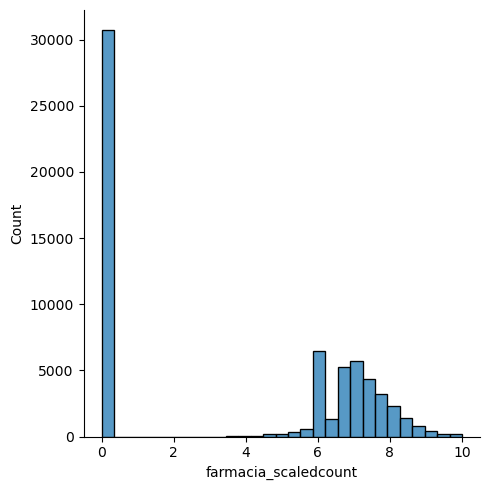

In [17]:
sns.displot(hex_gdf, x="farmacia_scaledcount")

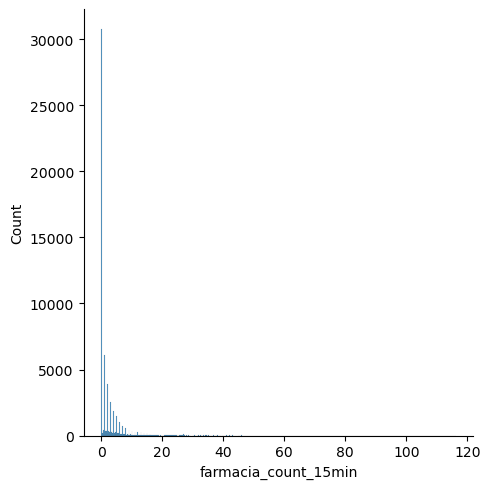

In [18]:
sns.displot(hex_gdf, x="farmacia_count_15min")

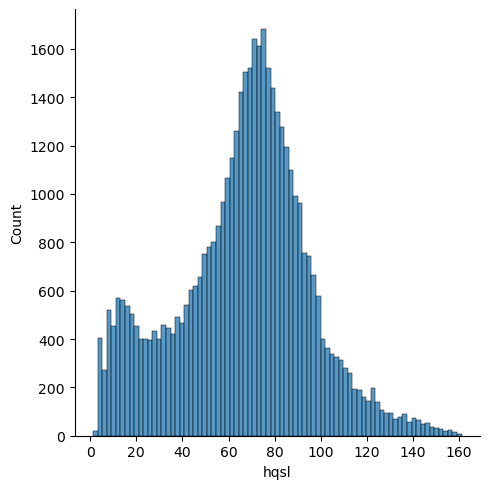

In [19]:
sns.displot(hex_gdf.loc[hex_gdf.supermercado_time>0],
            x=hex_gdf.loc[hex_gdf.supermercado_time>0,"hqsl"])

<Axes: >

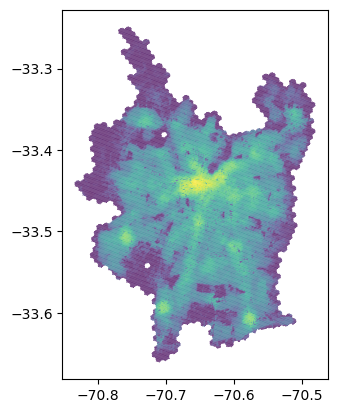

In [20]:
hex_gdf.plot('hqsl')

### Upload data

In [22]:
if save:
    processed_table_name = 'santiago_hexproximity_hqsl_4_5_kmh'
    aup.gdf_to_db_slow(hex_gdf, processed_table_name, 'projects_research', if_exists='replace')

# __Show and save some statistical data + create polar plots__

### Load data - Load source matrix (summary base table)

In [31]:
df_summary = pd.read_csv(grl_dir + 'source_matrix_v240621.csv',sep=';',encoding='iso-8859-1') #encoding='iso-8859-1'
df_summary.rename(columns={df_summary.columns[0]: 'Function'},inplace=True, errors='raise')
df_summary

,Function,Theme,Variable,Source name
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar
2,Supplies,GROCERIES,Bakeries and delis,bakeries
3,Supplies,GROCERIES,Local and mini markets,local_mini_market
4,Supplies,GROCERIES,CIty fairs,ferias
5,Supplies,GROCERIES,Supermarkets,supermercado
6,Supplies,SERVICES,Recycling center,centro_recyc
7,Caring,HEALTH,Neighborhood clinics,clinica_priv
8,Caring,HEALTH,Neighborhood clinics,clinica_pub
9,Caring,HEALTH,Hospitals,hospital_priv


In [4]:
hex_processed_table = 'santiago_hexproximity_hqsl_4_5_kmh'
hex_gdf = aup.gdf_from_db(hex_processed_table, 'projects_research')
print(hex_gdf.shape)
hex_gdf.head(2)

(63727, 207)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,8ab2c5540647fff,"POLYGON ((-70.67723 -33.43729, -70.67786 -33.4...",2.962535,4.001,6.049196,2.001,7.580963,2.001,50.542861,0.001,...,36.094867,7.988491,15.204718,22.882881,79.899882,20.964044,6.971818,28.120013,22.276371,131.062082
1,8ab2c546b0cffff,"POLYGON ((-70.62472 -33.58049, -70.62535 -33.5...",0.000000,0.001,0.000000,0.001,0.000000,0.001,0.000000,0.001,...,0.000000,9.206629,0.000000,6.159570,0.000000,3.797782,0.000000,0.000000,5.215651,27.949301


### Base data required - Social functions columns

##### Get social function count columns

In [5]:
parameters_dict = {'supplying':{'groceries':['carniceria','hogar','local_mini_market','ferias','supermercado']},
                   'caring':{'health':['clinica_priv','clinica_pub','hospital_priv','hospital_pub','consult_ado_priv','consult_ado_pub','residencia_adumayor','farmacia'],
                            'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']},
                   'living':{'errands_paperwork':['civic_office','tax_collection','social_security','banco'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big']},
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']},
                   'learning':{'education':['edu_basica_priv','edu_basica_pub','edu_media_priv','edu_media_pub','jardin_inf_pub','jardin_inf_priv','edu_especial_priv','edu_especial_pub']},
                   'working':{'sustainable_mobility':['ciclovias','paradas_tp','paradas_tp_tren','paradas_tp_metro']}}

social_fn_cols = []

for k in parameters_dict.keys():
    social_fn_cols.append(k+'_count')

# Show
social_fn_cols

['supplying_count',
 'caring_count',
 'living_count',
 'enjoying_count',
 'learning_count',
 'working_count']

### Show statistical data

##### Show statistical summary (__All data__)

In [6]:
summary_cols = social_fn_cols
if 'hqsl' not in summary_cols:
    summary_cols.append('hqsl')

hex_gdf[summary_cols].describe()

,supplying_count,caring_count,living_count,enjoying_count,learning_count,working_count,hqsl
count,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000,63727.000000
mean,12.852586,6.257793,8.350689,7.498743,7.601704,9.614869,52.176384
std,9.653409,5.579958,6.044387,3.817063,6.118641,6.788923,34.810664
min,0.000000,0.000000,0.000000,1.273478,0.000000,0.000000,1.273478
25%,2.248224,0.474227,2.645092,4.631807,0.569494,3.789657,15.875938
50%,14.253406,6.039708,8.277403,6.409768,8.363731,10.266372,57.145499
75%,21.392444,10.161980,12.365938,9.462944,11.938987,14.560398,78.133185
max,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,161.503686


##### Show res value by source name (__All data__)

In [10]:
df_summary['res_value'] = np.nan

for source in df_summary['Source name']:
    if pd.isna(source):
        continue
    for col in hex_gdf.columns:
        if source in col and 'scaled' in col:
            df_summary.loc[df_summary['Source name']==source, 'res_value'] = hex_gdf[col].mean()
df_summary

,Function,Theme,Variable,Source name,res_value
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria,3.171393
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar,3.045428
2,Supplies,GROCERIES,Bakeries and delis,bakeries,3.698732
3,Supplies,GROCERIES,Local and mini markets,local_mini_market,3.918096
4,Supplies,GROCERIES,CIty fairs,ferias,4.099294
...,...,...,...,...,...
59,Working,WORKPLACES,NaN,oficinas,1.986439
60,Working,SUSTAINABLE MOBILITY,Bike lanes,ciclovias,3.926354
61,Working,SUSTAINABLE MOBILITY,Bus stops,paradas_tp,1.774073
62,Working,SUSTAINABLE MOBILITY,Train stations,paradas_tp_tren,0.186725


## Filter data by spatial area (For Spider plots and hex analysis)

### Load data - Load areas of analysis

In [ ]:
#santiago_aoi = aup.gdf_from_db('santiago_aoi','projects_research')

In [ ]:
alameda = gpd.read_file(grl_dir + "buffer_800m_nueva_alameda_32719.gpkg")
alameda = alameda.to_crs("EPSG:4326")

santiago_viv = gpd.read_file(grl_dir + "viviendas_por_tipo_mnz_32719.gpkg")
santiago_viv = santiago_viv.to_crs("EPSG:4326")

In [207]:
alameda = gpd.read_file(grl_dir + "buffer 800m nueva alameda.shp")
alameda['name'] = 'alameda'
alameda = alameda.to_crs("EPSG:4326")

alameda_poniente = gpd.read_file(grl_dir + 'alameda_poniente.gpkg')
alameda_poniente['name'] = 'alameda_poniente'
alameda_oriente = gpd.read_file(grl_dir + 'alameda_oriente.gpkg')
alameda_oriente['name'] = 'alameda_oriente'

unidades_vecinales = gpd.read_file(grl_dir + 'unidades_vecinales.gpkg')
unidades_vecinales['name'] = unidades_vecinales['COD_UNICO_']
unidades_vecinales = unidades_vecinales[['name','geometry']]

comuna_cerro_navia = gpd.read_file(grl_dir + 'comunas_cerro_navia.gpkg')
comuna_cerro_navia['name'] = 'comuna_cerro_navia'
comuna_cerro_navia = comuna_cerro_navia[['name','geometry']]
comuna_las_condes = gpd.read_file(grl_dir + 'comuna_las_condes.gpkg')
comuna_las_condes['name'] = 'comuna_las_condes'
comuna_las_condes = comuna_las_condes[['name','geometry']]
comuna_santiago = gpd.read_file(grl_dir + 'comunas_santiago.gpkg')
comuna_santiago['name'] = 'comuna_santiago'
comuna_santiago = comuna_santiago[['name','geometry']]

zona_urbana = gpd.read_file(grl_dir + 'zona_urbana_santiago.gpkg')
zona_urbana['name'] = 'zona_urbana_santiago'
zona_urbana = zona_urbana[['name','geometry']]

In [208]:
aoi_all = pd.concat([alameda, alameda_poniente, alameda_oriente,
                unidades_vecinales, comuna_cerro_navia,
                comuna_las_condes, comuna_santiago,
                    zona_urbana], 
                ignore_index = True, axis = 0)
aoi_all

,id,geometry,name
0,1.0,"POLYGON ((-70.70775 -33.45031, -70.69297 -33.4...",alameda
1,1.0,"MULTIPOLYGON (((-70.67975 -33.44347, -70.67894...",alameda_poniente
2,1.0,"MULTIPOLYGON (((-70.67894 -33.45865, -70.67975...",alameda_oriente
3,NaN,"MULTIPOLYGON (((-70.65649 -33.43082, -70.65647...",13101_3
4,NaN,"MULTIPOLYGON (((-70.65156 -33.44447, -70.65151...",13101_40
5,NaN,"MULTIPOLYGON (((-70.69219 -33.44799, -70.69221...",13106_06
6,NaN,"MULTIPOLYGON (((-70.70518 -33.46140, -70.70518...",13106_16
7,NaN,"MULTIPOLYGON (((-70.68828 -33.46172, -70.68828...",13106_22
8,NaN,"MULTIPOLYGON (((-70.70877 -33.45257, -70.70856...",13117_19
9,NaN,"MULTIPOLYGON (((-70.66314 -33.39923, -70.66400...",comuna_cerro_navia


#### __Select area of interest manually!__

In [ ]:
zona_urbana_santiago.plot()

In [209]:
# 'Santiago_alameda' or 'Santiago_household'
area = 'zona_urbana_santiago'

In [210]:
aoi = aoi_all.loc[aoi_all.name==area].copy()

##### Clip hexagons to spatial area

In [211]:
hex_gdf['area_ha'] = hex_gdf.to_crs("EPSG:32719").area / 10000

In [212]:
# Get hexs area
def clip_data(hex_gdf, aoi):
    # Clip hexagons to spatial area of interest
    hex_clip = gpd.clip(hex_gdf, aoi)
    # Keep hexs only if at least 10% of hex inside area of interest
    hex_clip['area_clip'] = hex_clip.to_crs("EPSG:32719").area / 10000
    hex_clip['area_pct'] = hex_clip['area_clip'] / hex_clip['area_ha']
    hex_clip = hex_clip.loc[hex_clip.area_pct>=0.1].copy()
    # Create gdf for current spatial area of interest
    hex_list = list(hex_clip.hex_id.unique())
    hex_spatial = hex_gdf.loc[hex_gdf.hex_id.isin(hex_list)].copy()
    return hex_spatial

<AxesSubplot: >

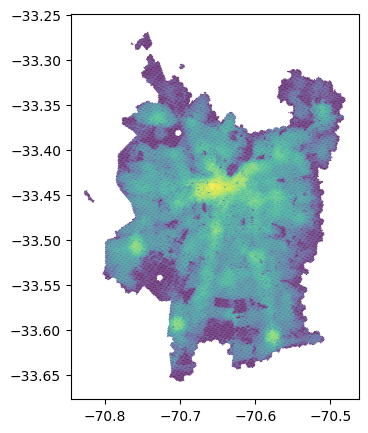

In [213]:
hex_spatial = clip_data(hex_gdf, aoi)
hex_spatial.plot('hqsl')

### Save urban zone

In [217]:
hex_processed_table = 'santiago_hexproximity_hqsl_4_5_kmh_urban_zone'
aup.gdf_to_db_slow(hex_spatial, hex_processed_table, 'projects_research')

##### Show statistical summary (__Selected spatial area only__)

In [218]:
hex_spatial[summary_cols].describe()

,supplying_count,caring_count,living_count,enjoying_count,learning_count,working_count,hqsl
count,56971.000000,56971.000000,56971.000000,56971.000000,56971.000000,56971.000000,56971.000000
mean,14.260796,6.968977,9.284222,7.842917,8.472701,10.646526,57.476140
std,9.215441,5.477285,5.697352,3.888776,5.883178,6.408358,32.955911
min,0.000000,0.000000,0.000000,1.273478,0.000000,0.000000,3.107815
25%,5.646784,1.622741,5.440579,4.755166,2.838023,5.571839,28.499874
50%,16.721164,6.754345,9.432518,6.611560,9.155301,10.809262,62.700580
75%,21.858404,10.591933,12.771884,9.689959,12.688619,15.258857,80.450786
max,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,161.503686


##### Show res value by source name (__Selected spatial area only__)

In [219]:
df_summary['res_value'] = np.nan

for source in df_summary['Source name']:
    if pd.isna(source):
        continue
    for col in hex_spatial.columns:
        if source in col and 'scaled' in col:
            df_summary.loc[df_summary['Source name']==source, 'res_value'] = hex_spatial[col].mean()
df_summary

,Function,Theme,Variable,Source name,res_value
0,Supplies,GROCERIES,Butcher/Fish Shops,carniceria,3.541884
1,Supplies,GROCERIES,Hardware/ Paint stores,hogar,3.363462
2,Supplies,GROCERIES,Bakeries and delis,bakeries,4.120571
3,Supplies,GROCERIES,Local and mini markets,local_mini_market,4.317581
4,Supplies,GROCERIES,CIty fairs,ferias,4.575552
...,...,...,...,...,...
59,Working,WORKPLACES,NaN,oficinas,2.217511
60,Working,SUSTAINABLE MOBILITY,Bike lanes,ciclovias,4.352882
61,Working,SUSTAINABLE MOBILITY,Bus stops,paradas_tp,1.984455
62,Working,SUSTAINABLE MOBILITY,Train stations,paradas_tp_tren,0.208868


#### __Save data (hex_spatial)__

In [220]:
# Name that would be used to distinguish between what was already uploaded and
# new processing considering Min and Maxs from hex res 8.
# Delete if not needed

# Save gdf
# hex_spatial.to_file(f'../../../output/data/santiago/SocialFunctions_log_{area}.geojson')

## Polar plots (spatial area)

In [221]:
import textwrap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
import math #importing the math functions
import matplotlib.pyplot as plt

### Spatial area polar plot - Shows all social functions

In [222]:
pi = math.pi

In [223]:
gdf_polar = hex_spatial[social_fn_cols].mean(axis=0)
gdf_polar

supplying_count    14.260796
caring_count        6.968977
living_count        9.284222
enjoying_count      7.842917
learning_count      8.472701
working_count      10.646526
hqsl               57.476140
dtype: float64

In [224]:
df = gdf_polar.copy()
df = pd.DataFrame(df).reset_index()
df.index = [0]*len(df)
df = df.rename(columns={'index':'social_fn',0:'value'})
df = df.pivot(columns='social_fn', values='value')
df

social_fn,caring_count,enjoying_count,hqsl,learning_count,living_count,supplying_count,working_count
0,6.968977,7.842917,57.47614,8.472701,9.284222,14.260796,10.646526


In [225]:
def wrap_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=rotation, )

def make_spider(df, row, color, title, alpha, linewidth, zorder, max_graph_value, graph_div):
    
    categories=list(df)[0:]
    N = len(categories)

    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
     
    plt.rc('figure', figsize=(5, 5), )
 
    ax = plt.subplot(1,1,1, polar=True, )
 
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
   
    plt.xticks(angles[:-1], categories, color='black', size=8,zorder=10)
    ax.tick_params(axis='x', rotation=0,pad=10, zorder=10)
    # ax.set_xlabel(labelpad=10)
    
    ax.set_rlabel_position(0)
    yticks = [i for i in range(0,max_graph_value+1, graph_div)]
    yticks_lab = [str(y) for y in yticks]
    plt.yticks(yticks, yticks_lab, color="black", size=10, zorder=10)
    plt.ylim(0,max_graph_value)
     
    
    values=df.reset_index().loc[row].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = color, linewidth=linewidth, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = alpha, zorder=zorder)
         
    wrap_labels(ax, 15, 0)
  
    # title = "Radar showing performance in each subject for "+ title
    # plt.title(title, fontsize=10, x = 0.5, y = 1.1)

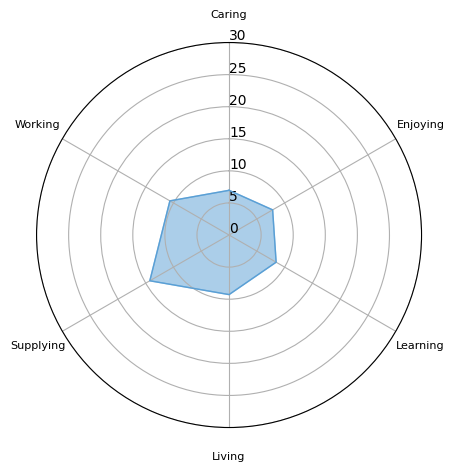

In [226]:
plt.figure()

color = '#599fd5'
df = df.rename(columns={'caring_count':'Caring',
                       'working_count':'Working',
                       'enjoying_count':'Enjoying',
                       'supplying_count':'Supplying',
                        'living_count':'Living',
                        'learning_count':'Learning'})
make_spider(row=0, df = df.drop(columns='hqsl'), title = area, 
            color = color, alpha=0.5, linewidth=1, zorder=-1,
            max_graph_value = 30, graph_div = 5)

plt.savefig(f'../../../output/figures/santiago/SocialFunctions_log_{area}.svg')

### Spatial area polar graph - Shows each social function's sources

In [227]:
social_fn_cols

['supplying_count',
 'caring_count',
 'living_count',
 'enjoying_count',
 'learning_count',
 'working_count',
 'hqsl']

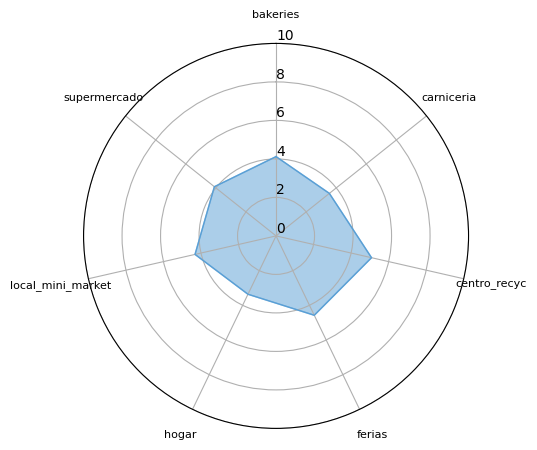

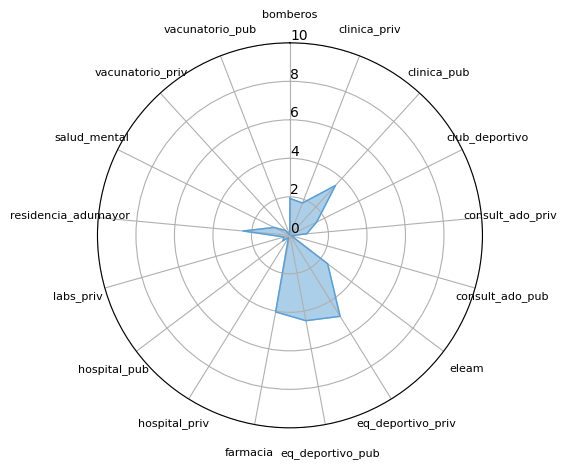

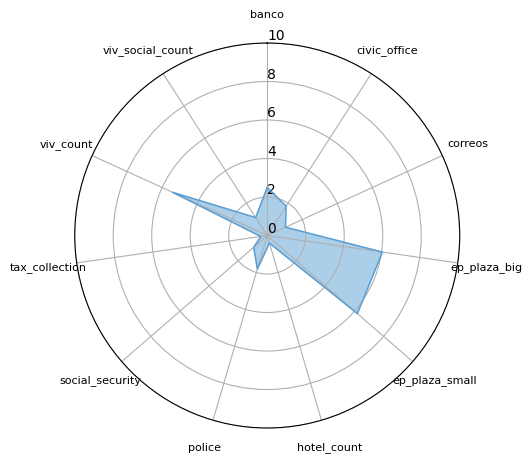

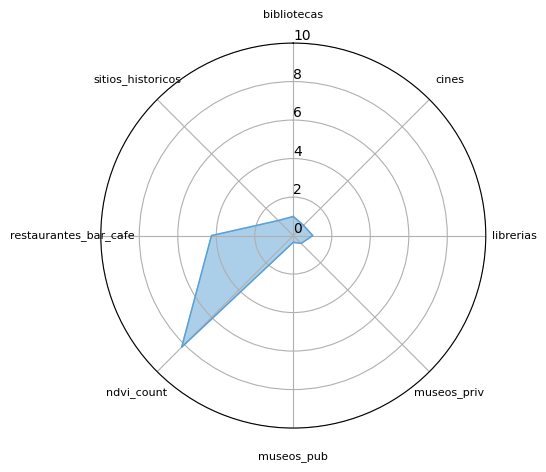

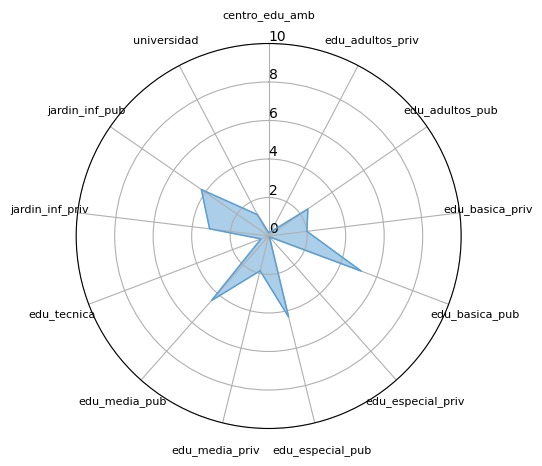

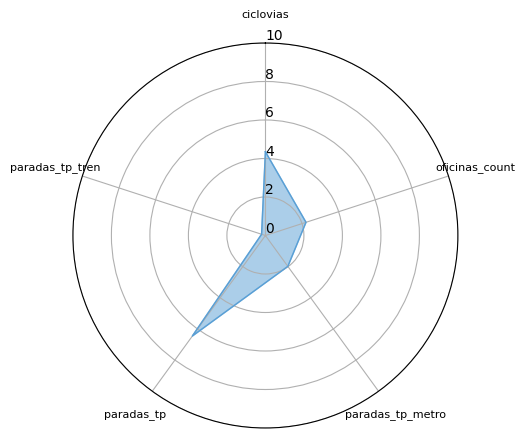

<Figure size 500x500 with 0 Axes>

In [228]:
for social_fn_graph in social_fn_cols:
    plt.figure()
    if social_fn_graph == 'hqsl':
        continue
    social_fn_graph = social_fn_graph[:-6]
    metric_list = []
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            metric_list.append(v+'_scaledcount')
    
    gdf_polar = hex_spatial[metric_list].mean(axis=0)
            
    df = gdf_polar.copy()
    df = pd.DataFrame(df).reset_index()
    df.index = [0]*len(df)
    df = df.rename(columns={'index':social_fn_graph, 0:'value'})
    df = df.pivot(columns=social_fn_graph, values='value')
    
    for val in parameters_dict[social_fn_graph].values():
        for v in val:
            df = df.rename(columns={v+'_scaledcount':v})
    
    make_spider(row=0, df = df, title = area, 
                color = color, alpha=0.5, linewidth=1, zorder=-1,
                max_graph_value = 10, graph_div = 2)
    
    plt.savefig(f'../../../output/figures/santiago/SocialFunctions_{social_fn_graph}_log_{area}.svg')

# Older Notebook code

### Pre-process data - Normalize data by social function before creating HQSL

In [ ]:
# Use hex8_gdf values as min/max values instead of hex9_gdf values?
use_hex8 = True

In [ ]:
hex_gdf = hex9_gdf.copy()
for sc in social_fn_cols:
    if use_hex8:
        hex_gdf[sc] = 5 * (hex_gdf[sc] - hex8_gdf[sc].min()) / (hex8_gdf[sc].max() - hex8_gdf[sc].min())
    else:
        hex_gdf[sc] = 5 * (hex_gdf[sc] - hex_gdf[sc].min()) / (hex_gdf[sc].max() - hex_gdf[sc].min())

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

### Pre-process data - Create HQSL

In [ ]:
hex_gdf['hqsl'] = hex_gdf[social_fn_cols[0]] + hex_gdf[social_fn_cols[1]] + hex_gdf[social_fn_cols[2]] + hex_gdf[social_fn_cols[3]] + hex_gdf[social_fn_cols[4]] + hex_gdf[social_fn_cols[5]]
hex_gdf.plot('hqsl')

In [ ]:
hex_gdf = hex_gdf.loc[hex_gdf.supermercado_time>0].copy()
hex_gdf.plot('hqsl')